In [1]:
addpath(genpath('../../../../src'))

# Transfer matrices and fixed points

This notebook demonstrates how to find fixed points of infinite one-dimensional transfer matrices with MPS methods, using the `Tensor` backend. It utilizes the functionalities defined in the notebooks on uniform MPS and local Hamiltonians (which should therefore be run first to generate the function files called from this notebook). Our discussion is based on the seventh chapter of the [lecture notes on tangent space methods for uniform MPS](https://doi.org/10.21468/SciPostPhysLectNotes.7) by Laurens Vanderstraeten, Jutho Haegeman and Frank Verstraete.

The contents of this notebook mirror that of a tutorial given at the [2020 school on Tensor Network based approaches to Quantum Many-Body Systems](http://quantumtensor.pks.mpg.de/index.php/schools/2020-school/) held in Bad Honnef, Germany, which can be found [here](https://github.com/leburgel/uniformMpsTutorial).

## 1 MPS as fixed points of one-dimensional transfer matrices

Matrix product states have been used extensively as a variational ansatz for ground states of local Hamiltonians. In recent years, it has been observed that they can also provide accurate approximations for fixed points of transfer matrices. In this notebook we investigate how tangent-space methods for MPS can be applied to one-dimensional transfer matrices.

A one-dimensional transfer matrix in the form of a *matrix product operator* (MPO) is given by

$$
T(O) = \sum_{\{i\}, \{j\}} \left( \dots O^{i_{n-1}, j_{n-1}} O^{i_{n}, j_{n}} O^{i_{n+1}, j_{n+1}} \dots \right)
\left | i_{n-1} \right \rangle \left \langle j_{n-1} \right | \otimes \left | i_{n} \right \rangle \left \langle j_{n} \right | \otimes \left | i_{n+1} \right \rangle \left \langle j_{n+1} \right | \dots \;,
$$

which can be represented diagrammatically as

<center><img src="./img/transferMpo.svg" alt="transferMpo"/></center>

Such an object naturally arises in the context of infinite two-dimensional tensor networks, which can be interpreted as an infinite power of a corresponding one-dimensional row-to-row transfer matrix. This means that the contraction of the network is equivalent to finding the leading eigenvector $\left | \Psi \right \rangle$, referred to as the *fixed point*, of the transfer matrix which satisfies the equation

$$T(O) \left | \Psi \right \rangle \propto \left | \Psi \right \rangle.$$

We can now propose an MPS ansatz for this fixed point, such that it obeys the eigenvalue equation

<center><img src="./img/fixedPoint.svg" alt="fixedPoint"/></center>

This MPS fixed point can be computed through a variation on the VUMPS algorithm introduced in the previous chapter, as will be explained in the next section. Suppose for now that we have managed to find an MPS representation $\left | \Psi(A) \right \rangle$ of the fixed point of $T(O)$. The corresponding eigenvalue $\Lambda$ is then given by

$$ \Lambda = \left \langle \Psi(\bar{A}) \middle | T \middle | \Psi(A) \right \rangle , $$

assuming as always that we are dealing with a properly normalized MPS. If we bring $\left | \Psi(A) \right \rangle$ in mixed canonical form, then $\Lambda$ is given by the network

<center><img src="./img/lambda.svg" alt="lambda"/></center>

We can contract this resulting infinite network by finding the fixed points of the left and right channel operators $T_L$ and $T_R$ which are defined as

<center><img src="./img/channels.svg" alt="channels"/></center>

The corresponding fixed points $F_L$ and $F_R$, also referred to as the left and right *environments*, satisfy

<center><img src="./img/environments.svg" alt="environments"/></center>

and can be normalized such that

<center><img src="./img/envNorm.svg" alt="envNorm"/></center>

The eigenvalues $\lambda_L$ and $\lambda_R$ have to correspond to the same value $\lambda$ by construction, so that $\Lambda$ is given by

$$ \Lambda = \lim_{N \to \infty} \lambda^N ,$$

where $N$ is the number of sites in the horizontal direction. Finally, we note that we can associate a *free energy density* $f = -\frac{1}{N} \log \Lambda = -\log \lambda$ to this MPS fixed point.


## 2 The VUMPS algorithm for MPOs

In order to formulate an algorithm for finding this MPS fixed point we start by stating the optimality condition it must satisfy in order to qualify as an approximate eigenvector of $T(O)$. Intuitively, what we would like to impose is that the residual $T(O) \left| \Psi \right \rangle - \Lambda \left | \Psi \right \rangle$ is equal to zero. While this condition can never be satisfied exactly for any MPS approximation, we can however demand that the tangent space projection of this residual vanishes,

$$
\mathcal{P}_A \left( T(O) \left| \Psi \right \rangle - \Lambda \left | \Psi \right \rangle \right) = 0,
$$

where $\mathcal{P}_A$ is the projector onto the tangent space to the MPS manifold at $A$. Similar to the Hamiltonian case, this projected residual can be characterized in terms of a tangent space gradient $G$,

$$
G = A_C' - A_L C' = A_c' - C' A_R,
$$

where $A_C'$ and $C'$ are now given by

<center><img src="./img/AcPrime2.svg" alt="AcPrime2"/></center>

and

<center><img src="./img/CPrime2.svg" alt="CPrime2"/></center>

The optimality condition for the fixed point MPS is then equivalent to having $||G|| = 0$. In addition, if the MPO defining the transfer matrix is hermitian then it can be shown that the optimality condition corresponds to the variational minimum of the free energy density introduced above. Similar to the Hamiltonian case, if we introduce operators $O_{A_C}(\cdot)$ and $O_C(\cdot)$ such that

$$
\begin{align}
O_{A_C}(A_C) = A_C', \\
O_{C}(C) = C',
\end{align}
$$

then it follows that the fixed point is characterized by the set of equations

$$
\begin{align}
O_{A_C}(A_C) \propto A_C, \\
O_{C}(C) \propto C, \\
A_C = A_L C = C A_R.
\end{align}
$$

The VUMPS algorithm for MPOs then corresponds to an iterative scheme for finding the solutions to these equations starting from a given set $\{A_L, A_C, A_R, C\}$ which consists of the following steps:

1. Find the left and right environments $F_L$ and $F_R$ and use these to solve the eigenvalue equations for $O_{A_C}$ and $O_C$, giving new center tensors $\tilde{A}_C$ and $\tilde{C}$.

2. From these new center tensors, extract the $\tilde{A}_L$ and $\tilde{A}_R$ that minimize $||\tilde{A}_C - \tilde{A}_L \tilde{C}||$ and $||\tilde{A}_C - \tilde{C} \tilde{A}_L||$ using the `minAcC` routine from the previous chapter.

3. Update the set of tensors $\{A_L, A_C, A_R, C\} \leftarrow \{\tilde{A}_L, \tilde{A}_C, \tilde{A}_R, \tilde{C}\}$ and evaluate the optimality condition $\varepsilon = \left | \left | O_{A_C} (A_C) - A_L O_C(C) \right | \right |$.

4. If the optimality condition lies above the given tolerance, repeat.

#### Implementing the VUMPS algorithm

We start by implementing the routines for finding and normalizing the left and right environments of the channel operators.

In [2]:
%%file leftEnvironment.m
function [lam, Fl] = leftEnvironment(O, Al, tol)
    % Computes the left environment as the fixed point of the left channel operator.
    %
    % Parameters
    % ----------
    % O : :class:`Tensor` (d, d, d, d)
    %     MPO tensor,
    %     ordered top-right-bottom-left.
    % Al : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     left-orthonormal.
    % tol : float, optional
    %     tolerance for eigenvalue solver
    %
    % Returns
    % -------
    % lam : double
    %     Leading left eigenvalue.
    % Fl : :class:`Tensor` (D, d, D)
    %     left environment,
    %     ordered bottom-middle-top.
    
    tol = max(tol, 1e-14);
    
    % initialize handle for the action of the left channel operator on a given input tensor
    channelLeft = @(x) contract(x, [5, 3, 1], Al, [1, 2, -3], conj(Al), [5, 4, -1], O, [2, -2, 4, 3]);
    % compute the largest magnitude eigenvalue and corresponding eigenvector
    x0 = similar([], Al, 1, O, 4, Al, 1, 'Conj', [false, true, true]);
    [Fl, lam] = eigsolve(channelLeft, x0, 1, 'largestabs', 'Tol', tol);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/leftEnvironment.m'.


In [3]:
%%file rightEnvironment.m
function [lam, Fr] = rightEnvironment(O, Ar, tol)
    % Computes the right environment as the fixed point of the right channel operator.
    %
    % Parameters
    % ----------
    % O : :class:`Tensor` (d, d, d, d)
    %     MPO tensor,
    %     ordered top-right-bottom-left.
    % Ar : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     right-orthonormal.
    % tol : float, optional
    %     tolerance for eigenvalue solver
    %
    % Returns
    % -------
    % lam : double
    %     Leading right eigenvalue.
    % Fr : :class:`Tensor` (D, d, D)
    %     right environment,
    %     ordered top-middle-bottom.

    tol = max(tol, 1e-14);
    
    % initialize handle for the action of the left channel operator on a given input tensor
    channelRight = @(x) contract(x, [1, 3, 5], Ar, [-1, 2, 1], conj(Ar), [-3, 4, 5], O, [2, 3, 4, -2]);
    % compute the largest magnitude eigenvalue and corresponding eigenvector
    x0 = similar([], Ar, 3, O, 2, Ar, 3, 'Conj', [true, true, false]);
    [Fr, lam] = eigsolve(channelRight, x0, 1, 'largestabs', 'Tol', tol);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/rightEnvironment.m'.


In [4]:
%%file environments.m
function [lam, Fl, Fr] = environments(O, Al, Ar, C, tol)
    % Compute the left and right environments of the channel operators
    % as well as the corresponding eigenvalue.
    %
    % Parameters
    % ----------
    % O : :class:`Tensor` (d, d, d, d)
    %     MPO tensor,
    %     ordered top-right-bottom-left.
    % Al : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     left-orthonormal.
    % Ar : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     right-orthonormal.
    % C : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right.
    % tol : float, optional
    %     tolerance for eigenvalue solver
    %
    % Returns
    % -------
    % lam : double
    %     Leading eigenvalue of the channel
    %     operators.
    % Fl : :class:`Tensor` (D, d, D)
    %     left environment,
    %     ordered bottom-middle-top.
    % Fr : :class:`Tensor` (D, d, D)
    %     right environment,
    %     ordered top-middle-bottom.
    
    arguments
        O
        Al
        Ar
        C
        tol = 1e-5
    end

    tol = max(tol, 1e-14);
    
    [lam, Fl] = leftEnvironment(O, Al, tol);
    [~, Fr] = rightEnvironment(O, Ar, tol);
    lam = real(lam);
    
    overlap = contract(Fl, [1, 3, 2], Fr, [5, 3, 4], C, [2, 5], conj(C), [1, 4]);
    Fl = Fl / overlap;
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/environments.m'.


Next we implement the action of the effective operators $O_{A_C}$ and $O_C$ on a given input tensor,

<center><img src="./img/O_Ac.svg" alt="O_Ac"/></center>

and

<center><img src="./img/O_C.svg" alt="O_C"/></center>

In [5]:
%%file O_Ac.m
function y = O_Ac(x, O, Fl, Fr, lam)
    % Action of the operator O_Ac on a given tensor.
    %
    % Parameters
    % ----------
    % x : :class:`Tensor` (D, d, D)
    %     Tensor of size (D, d, D)
    % O : :class:`Tensor` (d, d, d, d)
    %     MPO tensor,
    %     ordered left-top-right-bottom.
    % Fl : :class:`Tensor` (D, d, D)
    %     left environment,
    %     ordered bottom-middle-top.
    % Fr : :class:`Tensor` (D, d, D)
    %     right environment,
    %     ordered top-middle-bottom.
    % lam : float
    %     Leading eigenvalue.
    %
    % Returns
    % -------
    % y : :class:`Tensor` (D, d, D)
    %     Result of the action of O_Ac on the tensor x.
    
    y = contract(Fl, [-1, 2, 1], Fr, [4, 5, -3], x, [1, 3, 4], O, [3, 5, -2, 2]) / lam;
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/O_Ac.m'.


In [6]:
%%file O_C.m
function y = O_C(x, Fl, Fr)
    % Action of the operator O_C on a given tensor.
    %
    % Parameters
    % ----------
    % x : :class:`Tensor` (D, D)
    %     Tensor of size (D, D)
    % Fl : :class:`Tensor` (D, d, D)
    %     left environment,
    %     ordered bottom-middle-top.
    % Fr : :class:`Tensor` (D, d, D)
    %     right environment,
    %     ordered top-middle-bottom.
    %
    % Returns
    % -------
    % y : :class:`Tensor` (D, d, D)
    %     Result of the action of O_C on the tensor x.
    
    y = contract(Fl, [-1, 3, 1], Fr, [2, 3, -2], x, [1, 2]);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/O_C.m'.


This then allows to define a new routine `calcNewCenterMpo` which finds the new center tensors $\tilde{A}_C$ and $\tilde{C}$ by solving the eigenvalue problems for $O_{A_C}$ and $O_C$.

In [7]:
%%file calcNewCenterMpo.m
function [AcTilde, CTilde] = calcNewCenterMpo(O, Ac, C, Fl, Fr, lam, tol)
    % Find new guess for Ac and C as fixed points of the maps O_Ac and O_C.
    %
    % Parameters
    % ----------
    % O : :class:`Tensor` (d, d, d, d)
    %     MPO tensor,
    %     ordered left-top-right-bottom.
    % Ac : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     center gauge.
    % C : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right.
    % Fl : :class:`Tensor` (D, d, D)
    %     left environment,
    %     ordered bottom-middle-top.
    % Fr : :class:`Tensor` (D, d, D)
    %     right environment,
    %     ordered top-middle-bottom.
    % lam : double
    %     Leading eigenvalue.
    % tol : double, optional
    %     current tolerance
    %
    % Returns
    % -------
    % AcTilde : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     center gauge.
    % CTilde : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right.
    
    arguments
        O
        Ac
        C
        Fl
        Fr
        lam
        tol = 1e-5
    end
    
    tol = max(tol, 1e-14);
    
    % compute fixed points of O_Ac and O_C
    [AcTilde, ~] = eigsolve(@(x) O_Ac(x, O, Fl, Fr, lam), Ac, 1, 'largestabs', 'Tol', tol);
    [CTilde, ~] = eigsolve(@(x) O_C(x, Fl, Fr), C, 1, 'largestabs', 'Tol', tol);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/calcNewCenterMpo.m'.


Since the `minAcC` routine to extract a new set of mixed gauge MPS tensors from the updated $\tilde{A}_C$ and $\tilde{C}$ can be reused from the previous chapter, we now have all the tools needed to implement the VUMPS algorithm for MPOs.

In [8]:
%%file vumpsMpo.m
function [lam, Al, Ar, C, Ac, Fl, Fr] = vumpsMpo(O, D, A0, tol, tolFactor, verbose)
    % Find the fixed point MPS of a given MPO using VUMPS.

    % Parameters
    % ----------
    % O : :class:`Tensor` (d, d, d, d)
    %     MPO tensor,
    %     ordered left-top-right-bottom.
    % D : int
    %     Bond dimension
    % A0 : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     initial guess.
    % tol : float
    %     Relative convergence criterium.
    %
    % Returns
    % -------
    % lam : float
    %     Leading eigenvalue.
    % Al : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     left orthonormal.
    % Ar : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     right orthonormal.
    % Ac : :class:`Tensor` (D, d, D)
    %     MPS tensor with 3 legs,
    %     ordered left-bottom-right,
    %     center gauge.
    % C : :class:`Tensor` (D, D)
    %     Center gauge with 2 legs,
    %     ordered left-right.
    % Fl : :class:`Tensor` (D, d, D)
    %     left environment,
    %     ordered bottom-middle-top.
    % Fr : :class:`Tensor` (D, d, D)
    %     right environment,
    %     ordered top-middle-bottom.
    
    arguments
        O
        D
        A0 = []
        tol = 1e-4
        tolFactor = 1e-2
        verbose = true
    end
    
    tol = max(tol, 1e-14);
    delta = 1e-4;
    
    % if no initial guess, random one
    if isempty(A0)
        A0 = createMPS(D, d);
    end
    
    % go to mixed gauge
    [Al, Ar, C, Ac] = mixedCanonical(A0, [], [], delta*tolFactor^2);
    
    flag = true;
    i = 0;
    
    while flag
        i = i + 1;
        
        % compute left and right environments and corrsponding eigenvalue
        [lam, Fl, Fr] = environments(O, Al, Ar, C, delta*tolFactor);
        
        % calculate convergence measure, check for convergence
        G = O_Ac(Ac, O, Fl, Fr, lam) - contract(Al, [-1, -2, 1], O_C(C, Fl, Fr), [1, -3]);
        delta = norm(G);
        if delta < tol
            flag = false;
        end
        
        % compute updates on Ac and C
        [AcTilde, CTilde] = calcNewCenterMpo(O, Ac, C, Fl, Fr, lam, delta*tolFactor);
        
        % find Al, Ar from AcTilde, CTilde
        [AlTilde, ArTilde, CTilde, AcTilde] = minAcC(AcTilde, CTilde, delta*tolFactor^2);
        
        % update tensors
        Al = AlTilde; Ar = ArTilde; C = CTilde; Ac = AcTilde;
        
        % print current eigenvalue
        if verbose
            fprintf('iteration:\t%d,\tenergy:\t%.12f\tgradient norm\t%.4e\n', i, lam, delta)
        end
    end
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/vumpsMpo.m'.


## 3 The two-dimensional classical Ising model

Next we apply the VUMPS algorithm for MPOs to the two-dimensional classical Ising model. To this end, consider classical spins $s_i = \pm 1$ placed on the sites of an infinite square lattice which interact according to the nearest-neighbor Hamiltonian

$$H = -J \sum_{\langle i,j \rangle} s_i s_j \,.$$

We now wish to compute the corresponding partition function,

$$ \mathcal{Z} = \sum_{\{s_i\}} \text{e}^{-\beta H({\{s_i\}})},$$

using our freshly implemented algorithm. In order to do this we first rewrite this partition function as the contraction of an infinite two-dimensional tensor network,

<center><img src="./img/Z.svg" alt="Z"/></center>

where every edge in the network has bond dimension $d = 2$. Here, the black dots represent $ \delta $-tensors

<center><img src="./img/delta.svg" alt="delta"/></center>

and the matrices $t$ encode the Boltzmann weights associated to each nearest-neighbor interaction,

<center><img src="./img/t.svg" alt="t"/></center>

In order to arrive at a translation invariant network corresponding to a single hermitian MPO tensor we can take the matrix square root $q$ of each Boltzmann matrix such that

<center><img src="./img/q.svg" alt="q"/></center>

and absorb the result symmetrically into the $\delta$-tensors at each vertex to define the MPO tensor

<center><img src="./img/O.svg" alt="O"/></center>

The partition function then becomes

<center><img src="./img/Z2.svg" alt="Z2p"/></center>

which precisely corresponds to an infinite power of a row-to-row transfer matrix $T(O)$ of the kind defined above. We can therefore use the VUMPS algorithm to determine its fixed point, where the corresponding eigenvalue automatically gives us the free energy density as explained before.

Having found this fixed point and its corresponding environments, we can easily evaluate expectation values of local observables. For example, say we want to find the expectation value of the magnetization at site $\mu$,

$$ \langle m \rangle = \frac{1}{\mathcal{Z}} \sum_{\{s_i\}} s_\mu \text{e}^{-\beta H({\{s_i\}})}.$$

We can access this quantity by introducing a magnetization tensor $M$, placing it at site $\mu$ and contracting the partition function network around it as

<center><img src="./img/Mexp.svg" alt="Mexp"/></center>

where the normalization factor $\mathcal{Z}$ in the denominator is taken care of by the same contraction where $O$ is left at site $\mu$ (which in this case is of course nothing more than the eigenvalue $\lambda$). The magnetization tensor $M$ is defined entirely analogously to the MPO tensor $O$, but where instead of a regular $\delta$-tensor the entry $i=j=k=l=2$ (using base-1 indexing) is set to $-1$ instead of $1$.

We can now define the routines for constructing the Ising MPO and magnetization tensor an computing local expectation values, as well as a routine that implements [Onsager's exact solution for this model](https://en.wikipedia.org/wiki/Ising_model#Onsager's_exact_solution) to compare our results to.

In [9]:
%%file isingO.m
function O = isingO(beta, J)
    % Gives the MPO tensor corresponding to the partition function of the 2d 
    % classical Ising model at a given temperature and coupling, obtained by
    % distributing the Boltzmann weights evenly over all vertices.
    %
    % Parameters
    % ----------
    % beta : float
    %     Inverse temperature.
    % J : float
    %     Coupling strength.
    %
    % Returns
    % -------
    % O : :class:`Tensor` (2, 2, 2, 2)
    %     MPO tensor,
    %     ordered top-right-bottom-left.

    % basic vertex delta tensor
    vertex = zeros(repmat(2, 1, 4));
    for i = 1:2
        sbs = num2cell(repmat(i, 1, 4));
        vertex(sbs{:}) = 1;
    end
    vertex = Tensor(vertex);
    % take matrix square root of Boltzmann weights and pull into vertex edges
    t = Tensor([exp(beta*J), exp(-beta*J); exp(-beta*J), exp(beta*J)]); t = repartition(t, [1, 1]);
    q = sqrtm(t);
    O = contract(q, [-1, 1], q, [-2, 2], q, [-3, 3], q, [-4, 4], vertex, [1, 2, 3, 4]);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/isingO.m'.


In [10]:
%%file isingM.m
function M = isingM(beta, J)
    % Gives the magnetization tensor for the 2d classical Ising model at a
    % given temperature and coupling.
    %
    % Parameters
    % ----------
    % beta : float
    %     Inverse temperature.
    % J : float
    %     Coupling strength.
    %
    % Returns
    % -------
    % M : :class:`Tensor` (2, 2, 2, 2)
    %     Magnetization tensor,
    %     ordered left-top-right-bottom.
    
    % basic vertex delta tensor
    vertex = zeros(repmat(2, 1, 4));
    for i = 1:2
        sbs = num2cell(repmat(i, 1, 4));
        vertex(sbs{:}) = 1;
    end
    vertex(2, 2, 2, 2) = -1;
    vertex = Tensor(vertex);
    % take matrix square root of Boltzmann weights and pull into vertex edges
    t = Tensor([exp(beta*J), exp(-beta*J); exp(-beta*J), exp(beta*J)]); t = repartition(t, [1, 1]);
    q = sqrtm(t);
    M = contract(q, [-1, 1], q, [-2, 2], q, [-3, 3], q, [-4, 4], vertex, [1, 2, 3, 4]);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/isingM.m'.


In [11]:
%%file expValMpo.m
function e = expValMpo(O, Ac, Fl, Fr)
    % Gives the expectation value of a local operator O.
    %
    % Parameters
    % ----------
    % O : :class:`Tensor` (2, 2, 2, 2)
    %     local operator of which we want to
    %     compute the expectation value,
    %     ordered top-right-bottom-left.
    % Ac : :class:`Tensor` (D, d, D)
    %     MPS tensor of the MPS fixed point,
    %     with 3 legs ordered left-bottom-right,
    %     center gauge.
    % Fl : :class:`Tensor` (D, d, D)
    %     left environmnt,
    %     ordered bottom-middle-top.
    % Fr : :class:`Tensor` (D, d, D)
    %     right environmnt,
    %     ordered top-middle-bottom.
    %
    % Returns
    % -------
    % e : double
    %     expectation value of the operator O.
    
    e = contract(   Fl, [1, 3, 2], ...
                    Ac, [2, 7, 5], ...
                    O, [7, 8, 6, 3], ...
                    conj(Ac), [1, 6, 4], ...
                    Fr, [5, 8, 4]);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/expValMpo.m'.


In [12]:
%%file isingExact.m
function [magnetization, free, energy] = isingExact(beta, J)
    % Exact Onsager solution for the 2d classical Ising Model
    % 
    %     Parameters
    %     ----------
    %     beta : float
    %         Inverse temperature.
    %     J : float
    %         Coupling strength.
    % 
    %     Returns
    %     -------
    %     magnetization : float
    %         Magnetization at given temperature and coupling.
    %     free : float
    %         Free energy at given temperature and coupling.
    %     energy : float
    %         Energy at given temperature and coupling.

    theta = 0:1e-6:pi/2;
    x = 2*sinh(2*J*beta)/cosh(2*J*beta)^2;
    if 1-(sinh(2*J*beta))^(-4)>0
        magnetization = (1-(sinh(2*J*beta))^(-4))^(1/8);
    else
        magnetization = 0;
    end
    free = -1/beta*(log(2*cosh(2*J*beta))+1/pi*trapz(theta,log(1/2*(1+sqrt(1-x^2*sin(theta).^2)))));
    K = trapz(theta,1./sqrt(1-x^2*sin(theta).^2));
    energy = -J*cosh(2*J*beta)/sinh(2*J*beta)*(1+2/pi*(2*tanh(2*J*beta)^2-1)*K);
end

Created file '/home/leburgel/git/TensorTrack/docs/src/examples/uniformMps/isingExact.m'.


We can now demonstrate the VUMPS algorithm for MPOs. We will fix $J = 1$ in the following, and investigate the behavior of the model as a function of temperature. Since we know the critical piont is located at $T_c = \frac{2}{\log\left(1 + \sqrt{2}\right)} \approx 2.26919$, let us first have a look at $T = 4$ and $T = 1$ far above and below the critical temperature, for which we expect a vanishing and non-vanishing magnetization respectively.

In [13]:
D = 12;
d = 2;
J = 1;
tol = 1e-8;
tolFactor = 1e-4;
A0 = createMPS(D, d);

T = 4;
fprintf('Running for T = %.4f\n', T)
beta = 1 / T;
O = isingO(beta, J);
M = isingM(beta, J);
[lam, Al, Ar, C, Ac, Fl, Fr] = vumpsMpo(O, D, A0, tol, tolFactor, true);
mag = abs(expValMpo(M, Ac, Fl, Fr) / expValMpo(O, Ac, Fl, Fr));
freeEnergy = -log(lam) / beta;
[~, freeEnergyExact] = isingExact(beta, J);
fprintf('\nFree energy: %.10f; \trelative difference with exact solution: %.4e\n', ...
                freeEnergy, abs((freeEnergy - freeEnergyExact) / freeEnergyExact))
fprintf('\nMagnetization: %.10f\n\n', mag)

T = 1;
fprintf('Running for T = %.4f\n', T)
beta = 1 / T;
O = isingO(beta, J);
M = isingM(beta, J);
[lam, Al, Ar, C, Ac, Fl, Fr] = vumpsMpo(O, D, A0, tol, tolFactor, true);
mag = abs(expValMpo(M, Ac, Fl, Fr) / expValMpo(O, Ac, Fl, Fr));
freeEnergy = -log(lam) / beta;
[magExact, freeEnergyExact] = isingExact(beta, J);
fprintf('\nFree energy: %.10f; \trelative difference with exact solution: %.4e\n', ...
                freeEnergy, abs((freeEnergy - freeEnergyExact) / freeEnergyExact))
fprintf('\nMagnetization: %.10f; \trelative difference with exact solution: %.4e\n', ...
                mag, abs((mag - magExact) / magExact))


Running for T = 4.0000
iteration:	1,	energy:	1.368895562189	gradient norm	1.3761e+00
iteration:	2,	energy:	2.134012743237	gradient norm	2.5997e-02
iteration:	3,	energy:	2.136366460032	gradient norm	7.1440e-05
iteration:	4,	energy:	2.136366478122	gradient norm	3.2529e-10

Free energy: -3.0364259141; 	relative difference with exact solution: 3.2919e-08

Magnetization: 0.0000000001

Running for T = 1.0000
iteration:	1,	energy:	4.354039087277	gradient norm	4.3820e+00
iteration:	2,	energy:	7.391405784890	gradient norm	5.4451e-03
iteration:	3,	energy:	7.391630034942	gradient norm	2.0650e-08
iteration:	4,	energy:	7.391630034938	gradient norm	3.8242e-15

Free energy: -2.0003482837; 	relative difference with exact solution: 3.8102e-09

Magnetization: 0.9992757520; 	relative difference with exact solution: 0.0000e+00


We clearly see that far from the critical point the VUMPS algorithm achieves excellent agreement with the exact solution efficiently at very small bond dimensions.

As a final demonstration, we compute the magnetization and free energy over a range from $T = 1$ to $T = 3.4$ and plot the results. Note that convergence of the algorithm slows down significantly near the critical point, as can be expected.

Bond dimension: D = 12


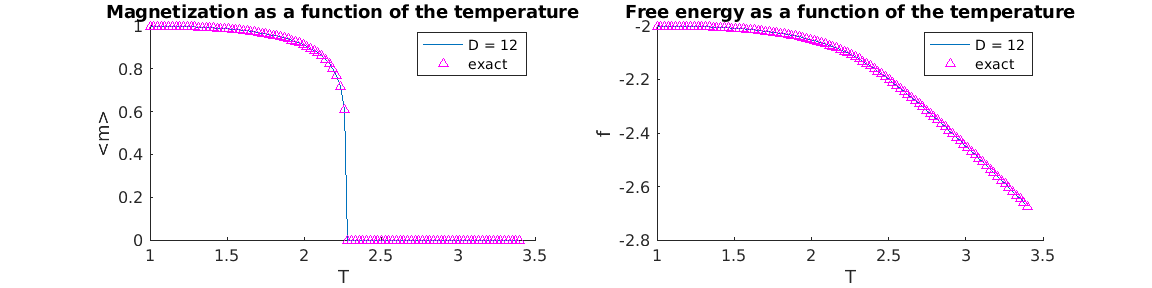

In [14]:
D = 12;
d = 2;
J = 1;
N = 100;

fprintf('Bond dimension: D = %d\n', D)
Al = createMPS(D, d);
% optimization parameters
tol = 1e-8;
tolFactor = 1e-2;
verbose = false;

Ts = linspace(1., 3.4, N);
magnetizations = zeros(1, N);
magnetizationsExact = zeros(1, N);
freeEnergies = zeros(1, N);
freeEnergiesExact = zeros(1, N);

for i = 1:N
    T = Ts(i);
    beta = 1/T;
    O = isingO(beta, J);
    M = isingM(beta, J);
    fprintf('Running for T = %.5f\r', T)
    
    [lam, Al, Ar, C, Ac, Fl, Fr] = vumpsMpo(O, D, Al, tol, tolFactor, verbose);
    magnetizations(i) = abs(expValMpo(M, Ac, Fl, Fr)/expValMpo(O, Ac, Fl, Fr));
    freeEnergies(i) = -log(lam) / beta;
    [magnetizationsExact(i), freeEnergiesExact(i)] = isingExact(beta, J);
end

%plot results
width = 6;
height = 3;
units = 'inches';
subplot(1, 2, 1)
hold on
plot(Ts, magnetizationsExact)
scatter(Ts, magnetizations, 'm', '^')
hold off
legend({sprintf('D = %d', D), 'exact'})
title('Magnetization as a function of the temperature')
xlabel('T')
ylabel('<m>')
subplot(1, 2, 2)
hold on
plot(Ts, freeEnergiesExact)
scatter(Ts, freeEnergies, 'm', '^')
hold off
legend({sprintf('D = %d', D), 'exact'})
title('Free energy as a function of the temperature')
xlabel('T')
ylabel('f')
set(gcf, 'Units', units, 'PaperUnits', units, 'position', [0 0 2*width height], 'PaperPosition', [0 0 2*width height]);

[thumbnail](img/Z2.svg)